# Baseline
python: 3.10.11

use ```Ctrl + ]``` to collapse all section :)

In [1]:
!gdown --folder 111itj-p0Q03HMHD9qlZE7V0ytxg8Halp
!mv baseline/* ./

Retrieving folder list
Retrieving folder 1cm83UdOV7pJYIZE8VOcLaY4GV8-iHGX- checkpoints
Retrieving folder 1_a2Lrb-yPHYO-wa27pa-__Qd-pokRu72 claim_verification
Retrieving folder 1blbmRYMdXnla5iAyn6fGt6RZ4wP6AQTo e20_bs32_7e-05_top4
Processing file 1izArjqrO39DlYmsPT2qrBaQctw9kWVhV val_acc=0.5202_model.1575.pt
Processing file 1-ndjah4Pan7Vm_bGrNIOMKu44veA-fe7 val_acc=0.5301_model.325.pt
Retrieving folder 19lhByrUoxiPJCwRGZU0UYu9cjPNbDuC2 sent_retrieval
Retrieving folder 1O6o8NOMT27uxpvkWPtfCZ8Pj8eyATIvx e3_bs64_2e-05_neg0.035_top4
Processing file 1sEDTyQFMl3ZyWK0YtE6BA1qIJ3XKfj-K model.200.pt
Processing file 1uX2X1DZRgeW5co4ahmzaZ8hfBc1pUB2C model.250.pt
Retrieving folder 1Ot0nFKEuPDZZabJLdH0hfLAankOV9oX6 e5_bs64_2e-05_neg0.027_top4
Processing file 1ACcUxYiK2H9tcO0KsvmQ7qggDvVBzy-n model.480.pt
Retrieving folder 1n7hnh4Phn7B0OF0VtsHYR5yxLn_8fUzr data
Processing file 1f6KMJ4-CWtOGhk0_ILDuulS1eHlmIc2w dev_doc8sent4.jsonl
Processing file 1csHYP7yKW_Oba2uUn4ayEBFftBcX4eYZ dev_doc8sent4.pkl
Pr

In [2]:
#@title
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 848.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.3/778.3 kB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 651.1/651.1 kB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 92.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

notebook1
## PART 1. Document retrieval

Prepare the environment and import all library we need

In [ ]:
# built-in libs
import json
import pickle
import re
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Set, Tuple, Union
# 3rd party libs
import hanlp
import opencc
import pandas as pd
import wikipedia
from hanlp.components.pipeline import Pipeline
from pandarallel import pandarallel

# our own libs
from utils import load_json

pandarallel.initialize(progress_bar=True, verbose=0, nb_workers=10)
wikipedia.set_lang("zh")

Preload the data.

In [ ]:
TRAIN_DATA = load_json("data/public_train_new.jsonl")
TEST_DATA = load_json("data/test_data_new.jsonl")
CONVERTER_T2S = opencc.OpenCC("t2s.json")
CONVERTER_S2T = opencc.OpenCC("s2t.json")

Data class for type hinting

In [ ]:
@dataclass
class Claim:
    data: str

@dataclass
class AnnotationID:
    id: int

@dataclass
class EvidenceID:
    id: int

@dataclass
class PageTitle:
    title: str

@dataclass
class SentenceID:
    id: int

@dataclass
class Evidence:
    data: List[List[Tuple[AnnotationID, EvidenceID, PageTitle, SentenceID]]]

### Helper function

For the sake of consistency, we convert traditional to simplified Chinese first before converting it back to traditional Chinese.  This is due to some errors occuring when converting traditional to traditional Chinese.

In [ ]:
def do_st_corrections(text: str) -> str:
    simplified = CONVERTER_T2S.convert(text)

    return CONVERTER_S2T.convert(simplified)

We use constituency parsing to separate part of speeches or so called constituent to extract noun phrases.  In the later stages, we will use the noun phrases as the query to search for relevant documents.  

In [ ]:
def get_nps_hanlp(
    predictor: Pipeline,
    d: Dict[str, Union[int, Claim, Evidence]],
) -> List[str]:
    claim = d["claim"]
    tree = predictor(claim)["con"]
    nps = [
        do_st_corrections("".join(subtree.leaves()))
        for subtree in tree.subtrees(lambda t: t.label() == "NP")
    ]

    return nps

Precision refers to how many related documents are retrieved.  Recall refers to how many relevant documents are retrieved.  

In [ ]:
def calculate_precision(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
) -> None:
    precision = 0
    count = 0

    for i, d in enumerate(data):
        if d["label"] == "NOT ENOUGH INFO":
            continue

        # Extract all ground truth of titles of the wikipedia pages
        # evidence[2] refers to the title of the wikipedia page
        gt_pages = set([
            evidence[2]
            for evidence_set in d["evidence"]
            for evidence in evidence_set
        ])

        predicted_pages = predictions.iloc[i]
        hits = predicted_pages.intersection(gt_pages)
        if len(predicted_pages) != 0:
            precision += len(hits) / len(predicted_pages)

        count += 1

    # Macro precision
    print(f"Precision: {precision / count}")


def calculate_recall(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
) -> None:
    recall = 0
    count = 0

    for i, d in enumerate(data):
        if d["label"] == "NOT ENOUGH INFO":
            continue

        gt_pages = set([
            evidence[2]
            for evidence_set in d["evidence"]
            for evidence in evidence_set
        ])
        predicted_pages = predictions.iloc[i]
        hits = predicted_pages.intersection(gt_pages)
        recall += len(hits) / len(gt_pages)
        count += 1

    print(f"Recall: {recall / count}")

The default amount of documents retrieved is at most five documents.  This `num_pred_doc` can be adjusted based on your objective.  Save data in jsonl format.

In [ ]:
def save_doc(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
    mode: str = "train",
    num_pred_doc: int = 8,
) -> None:
    with open(
        f"data/{mode}_doc{num_pred_doc}.jsonl",
        "w",
        encoding="utf8",
    ) as f:
        for i, d in enumerate(data):
            d["predicted_pages"] = list(predictions.iloc[i])
            f.write(json.dumps(d, ensure_ascii=False) + "\n")

### Main function for document retrieval

In [ ]:
def get_pred_pages(series_data: pd.Series) -> Set[Dict[int, str]]:
    results = []
    tmp_muji = []
    # wiki_page: its index showned in claim
    mapping = {}
    claim = series_data["claim"]
    nps = series_data["hanlp_results"]
    first_wiki_term = []

    for i, np in enumerate(nps):
        # Simplified Traditional Chinese Correction
        wiki_search_results = [
            do_st_corrections(w) for w in wikipedia.search(np)
        ]

        # Remove the wiki page's description in brackets
        wiki_set = [re.sub(r"\s\(\S+\)", "", w) for w in wiki_search_results]
        wiki_df = pd.DataFrame({
            "wiki_set": wiki_set,
            "wiki_results": wiki_search_results
        })

        # Elements in wiki_set --> index
        # Extracting only the first element is one way to avoid extracting
        # too many of the similar wiki pages
        grouped_df = wiki_df.groupby("wiki_set", sort=False).first()
        candidates = grouped_df["wiki_results"].tolist()
        # muji refers to wiki_set
        muji = grouped_df.index.tolist()

        for prefix, term in zip(muji, candidates):
            if prefix not in tmp_muji:
                matched = False

                # Take at least one term from the first noun phrase
                if i == 0:
                    first_wiki_term.append(term)

                # Walrus operator :=
                # https://docs.python.org/3/whatsnew/3.8.html#assignment-expressions
                # Through these filters, we are trying to figure out if the term
                # is within the claim
                if (((new_term := term) in claim) or
                    ((new_term := term.replace("·", "")) in claim) or
                    ((new_term := term.split(" ")[0]) in claim) or
                    ((new_term := term.replace("-", " ")) in claim)):
                    matched = True

                elif "·" in term:
                    splitted = term.split("·")
                    for split in splitted:
                        if (new_term := split) in claim:
                            matched = True
                            break

                if matched:
                    # post-processing
                    term = term.replace(" ", "_")
                    term = term.replace("-", "")
                    results.append(term)
                    mapping[term] = claim.find(new_term)
                    tmp_muji.append(new_term)

    # 5 is a hyperparameter
    if len(results) > 8:
        assert -1 not in mapping.values()
        results=sorted(mapping, key=mapping.get)[:8]
    elif len(results) < 1:
        results = first_wiki_term
    return set(results)

### Step 1. Get noun phrases from hanlp consituency parsing tree

Setup [HanLP](https://github.com/hankcs/HanLP) predictor (1 min)

In [ ]:
predictor = (hanlp.pipeline().append(
    hanlp.load("FINE_ELECTRA_SMALL_ZH"),
    output_key="tok",
).append(
    hanlp.load("CTB9_CON_ELECTRA_SMALL"),
    output_key="con",
    input_key="tok",
))

100%  43.5 MiB  11.5 MiB/s ETA:  0 s [=========================================]
Decompressing /root/.hanlp/tok/fine_electra_small_20220615_231803.zip to /root/.hanlp/tok
100%  26.7 KiB  26.7 KiB/s ETA:  0 s [=========================================]
Decompressing /root/.hanlp/utils/char_table_20210602_202632.json.zip to /root/.hanlp/utils
100%  41.2 KiB  41.2 KiB/s ETA:  0 s [=========================================]
Decompressing /root/.hanlp/transformers/electra_zh_small_20210706_125427.zip to /root/.hanlp/transformers
100%  54.8 MiB   6.8 MiB/s ETA:  0 s [=========================================]
Decompressing /root/.hanlp/constituency/ctb9_con_electra_small_20220215_230116.zip to /root/.hanlp/constituency


We will skip this process which for creating parsing tree when demo on class

In [ ]:
hanlp_file = f"data/hanlp_con_results.pkl"
if Path(hanlp_file).exists():
    with open(hanlp_file, "rb") as f:
        hanlp_results = pickle.load(f)
else:
    hanlp_results = [get_nps_hanlp(predictor, d) for d in TRAIN_DATA]
    with open(hanlp_file, "wb") as f:
        pickle.dump(hanlp_results, f)

Get pages via wiki online api

In [ ]:
doc_path = f"data/train_doc8.jsonl"
if Path(doc_path).exists():
    with open(doc_path, "r", encoding="utf8") as f:
        predicted_results = pd.Series([
            set(json.loads(line)["predicted_pages"])
            for line in f
        ])
else:
    train_df = pd.DataFrame(TRAIN_DATA)
    train_df.loc[:, "hanlp_results"] = hanlp_results
    predicted_results = train_df.apply(get_pred_pages, axis=1)
    save_doc(TRAIN_DATA, predicted_results, mode="train")

### Step 2. Calculate our results

In [ ]:
print(predicted_results)

0        {夢, 作者, 仲夏夜_(羅文專輯), 天衛三, 軌道, 仲夏夜之夢_(消歧義), 磁層, ...
1                     {北冰洋, 信天翁科, 牠, 南太平洋, 翼展, 太平洋, 世界, 鳥}
2        {主唱, 吉他, 阿沁, 吉他手, F._R._大衛, 詹雯婷, Faye_Disc, 飛_...
3          {香港國際機場, 小時, 2001年, 世界, 機場, 宇宙, 24小時, 24_(電視劇)}
4        {中華人民共和國, 歷史, 校長, 高等學校, 學校, 黨委書記和校長列入中央管理的高校, ...
                               ...                        
11615                {伯明翰大學, 伯明翰, 過敏性鼻炎, 研究, 鼻炎, 過敏, 諾貝爾獎}
11616                           {荃灣, 南豐紗廠, 翠豐臺, 新界, 2003年}
11617         {信義區_(臺北市), 仁愛路_(臺北市), 大安區_(臺北市), 中正區_(臺北市)}
11618               {文化部, 北, 北極殿, 國定古蹟, 南, 古蹟, 臺南北極殿, 臺南市}
11619                               {副校長, 國立臺東大學, 王家驥, 校長}
Length: 11620, dtype: object


In [ ]:
calculate_precision(TRAIN_DATA, predicted_results)
calculate_recall(TRAIN_DATA, predicted_results)

Precision: 0.2265334170263771
Recall: 0.8538230809357569


### Step 3. Repeat the same process on test set
Create parsing tree

In [ ]:
hanlp_test_file = f"data/hanlp_con_test_results.pkl"
if Path(hanlp_test_file).exists():
    with open(hanlp_test_file, "rb") as f:
        hanlp_results = pickle.load(f)
else:
    hanlp_results = [get_nps_hanlp(predictor, d) for d in TEST_DATA]
    with open(hanlp_test_file, "wb") as f:
        pickle.dump(hanlp_results, f)

Get pages via wiki online api

In [ ]:
test_doc_path = f"data/test_doc8.jsonl"
if Path(test_doc_path).exists():
    with open(test_doc_path, "r", encoding="utf8") as f:
        test_results = pd.Series(
            [set(json.loads(line)["predicted_pages"]) for line in f])
else:
    test_df = pd.DataFrame(TEST_DATA)
    test_df.loc[:, "hanlp_results"] = hanlp_results
    test_results = test_df.parallel_apply(get_pred_pages, axis=1)
    save_doc(TEST_DATA, test_results, mode="test")

notebook2
## PART 2. Sentence retrieval

Import some libs

In [3]:
# built-in libs
from pathlib import Path
from typing import Dict, List, Set, Tuple, Union

# third-party libs
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import json
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_scheduler,
)

from dataset import BERTDataset, Dataset

# local libs
from utils import (
    generate_evidence_to_wiki_pages_mapping,
    jsonl_dir_to_df,
    load_json,
    load_model,
    save_checkpoint,
    set_lr_scheduler,
)

pandarallel.initialize(progress_bar=True, verbose=0, nb_workers=10)

Global variable

In [4]:
SEED = 4090

TRAIN_DATA = load_json("data/public_train_new.jsonl")
TEST_DATA = load_json("data/test_data_new.jsonl")
DOC_DATA = load_json("data/train_doc8.jsonl")

LABEL2ID: Dict[str, int] = {
    "supports": 0,
    "refutes": 1,
    "NOT ENOUGH INFO": 2,
}
ID2LABEL: Dict[int, str] = {v: k for k, v in LABEL2ID.items()}

_y = [LABEL2ID[data["label"]] for data in TRAIN_DATA]
# GT means Ground Truth
TRAIN_GT, DEV_GT = train_test_split(
    DOC_DATA,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
    stratify=_y,
)

Preload wiki database (1 min)

In [5]:
wiki_pages = jsonl_dir_to_df("data/wiki-pages")
mapping = generate_evidence_to_wiki_pages_mapping(wiki_pages)
del wiki_pages

Reading and concatenating jsonl files in data/wiki-pages
Generate parse mapping


Transform to id to evidence_map mapping


### Helper function

Calculate precision for sentence retrieval

In [6]:
def evidence_macro_precision(
    instance: Dict,
    top_rows: pd.DataFrame,
) -> Tuple[float, float]:
    """Calculate precision for sentence retrieval
    This function is modified from fever-scorer.
    https://github.com/sheffieldnlp/fever-scorer/blob/master/src/fever/scorer.py

    Args:
        instance (dict): a row of the dev set (dev.jsonl) of test set (test.jsonl)
        top_rows (pd.DataFrame): our predictions with the top probabilities

        IMPORTANT!!!
        instance (dict) should have the key of `evidence`.
        top_rows (pd.DataFrame) should have a column `predicted_evidence`.

    Returns:
        Tuple[float, float]:
        [1]: relevant and retrieved (numerator of precision)
        [2]: retrieved (denominator of precision)
    """
    this_precision = 0.0
    this_precision_hits = 0.0

    # Return 0, 0 if label is not enough info since not enough info does not
    # contain any evidence.
    if instance["label"].upper() != "NOT ENOUGH INFO":
        # e[2] is the page title, e[3] is the sentence index
        all_evi = [[e[2], e[3]]
                   for eg in instance["evidence"]
                   for e in eg
                   if e[3] is not None]
        claim = instance["claim"]
        predicted_evidence = top_rows[top_rows["claim"] ==
                                      claim]["predicted_evidence"].tolist()

        for prediction in predicted_evidence:
            if prediction in all_evi:
                this_precision += 1.0
            this_precision_hits += 1.0

        return (this_precision /
                this_precision_hits) if this_precision_hits > 0 else 1.0, 1.0

    return 0.0, 0.0

Calculate recall for sentence retrieval

In [7]:
def evidence_macro_recall(
    instance: Dict,
    top_rows: pd.DataFrame,
) -> Tuple[float, float]:
    """Calculate recall for sentence retrieval
    This function is modified from fever-scorer.
    https://github.com/sheffieldnlp/fever-scorer/blob/master/src/fever/scorer.py

    Args:
        instance (dict): a row of the dev set (dev.jsonl) of test set (test.jsonl)
        top_rows (pd.DataFrame): our predictions with the top probabilities

        IMPORTANT!!!
        instance (dict) should have the key of `evidence`.
        top_rows (pd.DataFrame) should have a column `predicted_evidence`.

    Returns:
        Tuple[float, float]:
        [1]: relevant and retrieved (numerator of recall)
        [2]: relevant (denominator of recall)
    """
    # We only want to score F1/Precision/Recall of recalled evidence for NEI claims
    if instance["label"].upper() != "NOT ENOUGH INFO":
        # If there's no evidence to predict, return 1
        if len(instance["evidence"]) == 0 or all(
            [len(eg) == 0 for eg in instance]):
            return 1.0, 1.0

        claim = instance["claim"]

        predicted_evidence = top_rows[top_rows["claim"] ==
                                      claim]["predicted_evidence"].tolist()

        for evidence_group in instance["evidence"]:
            evidence = [[e[2], e[3]] for e in evidence_group]
            if all([item in predicted_evidence for item in evidence]):
                # We only want to score complete groups of evidence. Incomplete
                # groups are worthless.
                return 1.0, 1.0
        return 0.0, 1.0
    return 0.0, 0.0

Calculate the scores of sentence retrieval

In [8]:
def evaluate_retrieval(
    probs: np.ndarray,
    df_evidences: pd.DataFrame,
    ground_truths: pd.DataFrame,
    top_n: int = 5,
    cal_scores: bool = True,
    save_name: str = None,
) -> Dict[str, float]:
    """Calculate the scores of sentence retrieval

    Args:
        probs (np.ndarray): probabilities of the candidate retrieved sentences
        df_evidences (pd.DataFrame): the candiate evidence sentences paired with claims
        ground_truths (pd.DataFrame): the loaded data of dev.jsonl or test.jsonl
        top_n (int, optional): the number of the retrieved sentences. Defaults to 2.

    Returns:
        Dict[str, float]: F1 score, precision, and recall
    """
    df_evidences["prob"] = probs
    top_rows = (
        df_evidences.groupby("claim").apply(
        lambda x: x.nlargest(top_n, "prob"))
        .reset_index(drop=True)
    )

    if cal_scores:
        macro_precision = 0
        macro_precision_hits = 0
        macro_recall = 0
        macro_recall_hits = 0

        for i, instance in enumerate(ground_truths):
            macro_prec = evidence_macro_precision(instance, top_rows)
            macro_precision += macro_prec[0]
            macro_precision_hits += macro_prec[1]

            macro_rec = evidence_macro_recall(instance, top_rows)
            macro_recall += macro_rec[0]
            macro_recall_hits += macro_rec[1]

        pr = (macro_precision /
              macro_precision_hits) if macro_precision_hits > 0 else 1.0
        rec = (macro_recall /
               macro_recall_hits) if macro_recall_hits > 0 else 0.0
        f1 = 2.0 * pr * rec / (pr + rec)

    if save_name is not None:
        # write doc7_sent5 file
        with open(f"data/{save_name}", "w") as f:
            for instance in ground_truths:
                claim = instance["claim"]
                predicted_evidence = top_rows[
                    top_rows["claim"] == claim]["predicted_evidence"].tolist()
                instance["predicted_evidence"] = predicted_evidence
                f.write(json.dumps(instance, ensure_ascii=False) + "\n")

    if cal_scores:
        return {"F1 score": f1, "Precision": pr, "Recall": rec}

In [9]:
def evaluate_retrieval2(
    probs: np.ndarray,
    df_evidences: pd.DataFrame,
    ground_truths: pd.DataFrame,
    top_n: int = 5,
    cal_scores: bool = True,
    save_name: str = None,
) -> Dict[str, float]:
    """Calculate the scores of sentence retrieval

    Args:
        probs (np.ndarray): probabilities of the candidate retrieved sentences
        df_evidences (pd.DataFrame): the candiate evidence sentences paired with claims
        ground_truths (pd.DataFrame): the loaded data of dev.jsonl or test.jsonl
        top_n (int, optional): the number of the retrieved sentences. Defaults to 2.

    Returns:
        Dict[str, float]: F1 score, precision, and recall
    """
    df_evidences["prob"] = probs
    df_evidences2 = df_evidences[df_evidences["prob"] >=0.80]
    df_evidences2=df_evidences2.reset_index(drop=True)
    '''
    top_rows = (
        df_evidences2.groupby("claim")
    )
    '''
    if cal_scores:
        macro_precision = 0
        macro_precision_hits = 0
        macro_recall = 0
        macro_recall_hits = 0

        for i, instance in enumerate(ground_truths):
            macro_prec = evidence_macro_precision(instance, df_evidences2)
            macro_precision += macro_prec[0]
            macro_precision_hits += macro_prec[1]

            macro_rec = evidence_macro_recall(instance, df_evidences2)
            macro_recall += macro_rec[0]
            macro_recall_hits += macro_rec[1]

        pr = (macro_precision /
              macro_precision_hits) if macro_precision_hits > 0 else 1.0
        rec = (macro_recall /
               macro_recall_hits) if macro_recall_hits > 0 else 0.0
        f1 = 2.0 * pr * rec / (pr + rec)

    if save_name is not None:
        # write doc7_sent5 file
        with open(f"data/{save_name}", "w") as f:
            for instance in ground_truths:
                claim = instance["claim"]
                predicted_evidence = df_evidences2[
                    df_evidences2["claim"] == claim]["predicted_evidence"].tolist()
                instance["predicted_evidence"] = predicted_evidence
                f.write(json.dumps(instance, ensure_ascii=False) + "\n")

    if cal_scores:
        return {"F1 score": f1, "Precision": pr, "Recall": rec}

Inference script to get probabilites for the candidate evidence sentences

In [10]:
def get_predicted_probs(
    model: nn.Module,
    dataloader: Dataset,
    device: torch.device,
) -> np.ndarray:
    """Inference script to get probabilites for the candidate evidence sentences

    Args:
        model: the one from HuggingFace Transformers
        dataloader: devset or testset in torch dataloader

    Returns:
        np.ndarray: probabilites of the candidate evidence sentences
    """
    model.eval()
    probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            probs.extend(torch.softmax(logits, dim=1)[:, 1].tolist())

    return np.array(probs)

AicupTopkEvidenceBERTDataset class for AICUP dataset with top-k evidence sentences

In [11]:
class SentRetrievalBERTDataset(BERTDataset):
    """AicupTopkEvidenceBERTDataset class for AICUP dataset with top-k evidence sentences."""

    def __getitem__(
        self,
        idx: int,
        **kwargs,
    ) -> Tuple[Dict[str, torch.Tensor], int]:
        item = self.data.iloc[idx]
        sentA = item["claim"]
        sentB = item["text"]

        # claim [SEP] text
        concat = self.tokenizer(
            sentA,
            sentB,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
        )
        concat_ten = {k: torch.tensor(v) for k, v in concat.items()}
        if "label" in item:
            concat_ten["labels"] = torch.tensor(item["label"])

        return concat_ten

### Main function for sentence retrieval

In [12]:
def pair_with_wiki_sentences(
    mapping: Dict[str, Dict[int, str]],
    df: pd.DataFrame,
    negative_ratio: float,
) -> pd.DataFrame:
    """Only for creating train sentences."""
    claims = []
    sentences = []
    labels = []

    # positive
    for i in range(len(df)):
        if df["label"].iloc[i] == "NOT ENOUGH INFO":
            continue

        claim = df["claim"].iloc[i]
        evidence_sets = df["evidence"].iloc[i]
        for evidence_set in evidence_sets:
            sents = []
            for evidence in evidence_set:
                # evidence[2] is the page title
                page = evidence[2].replace(" ", "_")
                # the only page with weird name
                if page == "臺灣海峽危機#第二次臺灣海峽危機（1958）":
                    continue
                # evidence[3] is in form of int however, mapping requires str
                sent_idx = str(evidence[3])
                sents.append(mapping[page][sent_idx])

            whole_evidence = " ".join(sents)

            claims.append(claim)
            sentences.append(whole_evidence)
            labels.append(1)

    # negative
    for i in range(len(df)):
        if df["label"].iloc[i] == "NOT ENOUGH INFO":
            continue
        claim = df["claim"].iloc[i]

        evidence_set = set([(evidence[2], evidence[3])
                            for evidences in df["evidence"][i]
                            for evidence in evidences])
        predicted_pages = df["predicted_pages"][i]
        for page in predicted_pages:
            page = page.replace(" ", "_")
            try:
                page_sent_id_pairs = [
                    (page, sent_idx) for sent_idx in mapping[page].keys()
                ]
            except KeyError:
                # print(f"{page} is not in our Wiki db.")
                continue

            for pair in page_sent_id_pairs:
                if pair in evidence_set:
                    continue
                text = mapping[page][pair[1]]
                # `np.random.rand(1) <= 0.05`: Control not to add too many negative samples
                if text != "" and np.random.rand(1) <= negative_ratio:
                    claims.append(claim)
                    sentences.append(text)
                    labels.append(0)

    return pd.DataFrame({"claim": claims, "text": sentences, "label": labels})


def pair_with_wiki_sentences_eval(
    mapping: Dict[str, Dict[int, str]],
    df: pd.DataFrame,
    is_testset: bool = False,
) -> pd.DataFrame:
    """Only for creating dev and test sentences."""
    claims = []
    sentences = []
    evidence = []
    predicted_evidence = []

    # negative
    for i in range(len(df)):
        # if df["label"].iloc[i] == "NOT ENOUGH INFO":
        #     continue
        claim = df["claim"].iloc[i]

        predicted_pages = df["predicted_pages"][i]
        for page in predicted_pages:
            page = page.replace(" ", "_")
            try:
                page_sent_id_pairs = [(page, k) for k in mapping[page]]
            except KeyError:
                # print(f"{page} is not in our Wiki db.")
                continue

            for page_name, sentence_id in page_sent_id_pairs:
                text = mapping[page][sentence_id]
                if text != "":
                    claims.append(claim)
                    sentences.append(text)
                    if not is_testset:
                        evidence.append(df["evidence"].iloc[i])
                    predicted_evidence.append([page_name, int(sentence_id)])

    return pd.DataFrame({
        "claim": claims,
        "text": sentences,
        "evidence": evidence if not is_testset else None,
        "predicted_evidence": predicted_evidence,
    })

### Step 1. Setup training environment

Hyperparams

In [13]:
#@title  { display-mode: "form" }

MODEL_NAME = "bert-base-chinese"  #@param {type:"string"}
NUM_EPOCHS = 5  #@param {type:"integer"}
LR = 2e-5  #@param {type:"number"}
TRAIN_BATCH_SIZE = 64  #@param {type:"integer"}
TEST_BATCH_SIZE = 256  #@param {type:"integer"}
NEGATIVE_RATIO = 0.027  #@param {type:"number"}
VALIDATION_STEP = 80  #@param {type:"integer"}
TOP_N = 4  #@param {type:"integer"}

Experiment Directory

In [14]:
EXP_DIR = f"sent_retrieval/e{NUM_EPOCHS}_bs{TRAIN_BATCH_SIZE}_" + f"{LR}_neg{NEGATIVE_RATIO}_top{TOP_N}"
LOG_DIR = "logs/" + EXP_DIR
CKPT_DIR = "checkpoints/" + EXP_DIR

if not Path(LOG_DIR).exists():
    Path(LOG_DIR).mkdir(parents=True)

if not Path(CKPT_DIR).exists():
    Path(CKPT_DIR).mkdir(parents=True)

### Step 2. Combine claims and evidences

In [ ]:
train_df = pair_with_wiki_sentences(
    mapping,
    pd.DataFrame(TRAIN_GT),
    NEGATIVE_RATIO,
)
counts = train_df["label"].value_counts()
print("Now using the following train data with 0 (Negative) and 1 (Positive)")
print(counts)

dev_evidences = pair_with_wiki_sentences_eval(mapping, pd.DataFrame(DEV_GT))

Now using the following train data with 0 (Negative) and 1 (Positive)
0    7462
1    7028
Name: label, dtype: int64


### Step 3. Start training

Dataloader things

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = SentRetrievalBERTDataset(train_df, tokenizer=tokenizer)
val_dataset = SentRetrievalBERTDataset(dev_evidences, tokenizer=tokenizer)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE,
)
eval_dataloader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE)

Save your memory.

In [ ]:
del train_df

Trainer

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = set_lr_scheduler(optimizer, num_training_steps)

writer = SummaryWriter(LOG_DIR)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Please make sure that you are using gpu when training (5 min)

In [ ]:
progress_bar = tqdm(range(num_training_steps))
current_steps = 0

for epoch in range(NUM_EPOCHS):
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        writer.add_scalar("training_loss", loss.item(), current_steps)

        y_pred = torch.argmax(outputs.logits, dim=1).tolist()
        y_true = batch["labels"].tolist()

        current_steps += 1

        if current_steps % VALIDATION_STEP == 0 and current_steps > 0:
            print("Start validation")
            probs = get_predicted_probs(model, eval_dataloader, device)

            val_results = evaluate_retrieval2(
                probs=probs,
                df_evidences=dev_evidences,
                ground_truths=DEV_GT,
                top_n=TOP_N,
            )
            print(val_results)

            # log each metric separately to TensorBoard
            for metric_name, metric_value in val_results.items():
                writer.add_scalar(
                    f"dev_{metric_name}",
                    metric_value,
                    current_steps,
                )

            save_checkpoint(model, CKPT_DIR, current_steps)

print("Finished training!")

  0%|          | 0/1135 [00:00<?, ?it/s]

Start validation


  0%|          | 0/371 [00:00<?, ?it/s]

{'F1 score': 0.6745571502794905, 'Precision': 0.7262406467704488, 'Recall': 0.6297411198073449}
Start validation


  0%|          | 0/371 [00:00<?, ?it/s]

{'F1 score': 0.68472317796467, 'Precision': 0.6699334881454091, 'Recall': 0.7001806140878989}
Start validation


  0%|          | 0/371 [00:00<?, ?it/s]

{'F1 score': 0.692110054635601, 'Precision': 0.767296948151855, 'Recall': 0.6303431667670079}
Start validation


  0%|          | 0/371 [00:00<?, ?it/s]

{'F1 score': 0.6951336532332751, 'Precision': 0.7200495604469117, 'Recall': 0.6718844069837447}
Start validation


  0%|          | 0/371 [00:00<?, ?it/s]

{'F1 score': 0.6899098042143078, 'Precision': 0.7466557724835873, 'Recall': 0.6411800120409392}
Start validation


  0%|          | 0/371 [00:00<?, ?it/s]

{'F1 score': 0.7075569693927588, 'Precision': 0.7150903982631855, 'Recall': 0.7001806140878989}
Start validation


  0%|          | 0/371 [00:00<?, ?it/s]

{'F1 score': 0.6881291470015305, 'Precision': 0.7392935982339952, 'Recall': 0.6435881998795906}
Start validation


  0%|          | 0/371 [00:00<?, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Validation part (15 mins)

In [ ]:
ckpt_name = "model.480.pt"  #@param {type:"string"}
model = load_model(model, ckpt_name, CKPT_DIR)
print("Start final evaluations and write prediction files.")

train_evidences = pair_with_wiki_sentences_eval(
    mapping=mapping,
    df=pd.DataFrame(TRAIN_GT),
)
train_set = SentRetrievalBERTDataset(train_evidences, tokenizer)
train_dataloader = DataLoader(train_set, batch_size=TEST_BATCH_SIZE)

print("Start calculating training scores")
probs = get_predicted_probs(model, train_dataloader, device)
train_results = evaluate_retrieval2(
    probs=probs,
    df_evidences=train_evidences,
    ground_truths=TRAIN_GT,
    top_n=TOP_N,
    save_name=f"train_doc5sent{TOP_N}.jsonl",
)
print(f"Training scores => {train_results}")

print("Start validation")
probs = get_predicted_probs(model, eval_dataloader, device)
val_results = evaluate_retrieval2(
    probs=probs,
    df_evidences=dev_evidences,
    ground_truths=DEV_GT,
    top_n=TOP_N,
    save_name=f"dev_doc5sent{TOP_N}.jsonl",
)

print(f"Validation scores => {val_results}")

Start final evaluations and write prediction files.
Start calculating training scores


  0%|          | 0/1458 [00:00<?, ?it/s]

Training scores => {'F1 score': 0.7211139694243742, 'Precision': 0.7222495601881882, 'Recall': 0.7199819440264821}
Start validation


  0%|          | 0/371 [00:00<?, ?it/s]

Validation scores => {'F1 score': 0.7075569693927588, 'Precision': 0.7150903982631855, 'Recall': 0.7001806140878989}


### Step 4. Check on our test data
(5 min)

In [19]:
test_data = load_json("data/test_doc8.jsonl")

test_evidences = pair_with_wiki_sentences_eval(
    mapping,
    pd.DataFrame(test_data),
    is_testset=True,
)
test_set = SentRetrievalBERTDataset(test_evidences, tokenizer)
test_dataloader = DataLoader(test_set, batch_size=TEST_BATCH_SIZE)

print("Start predicting the test data")
probs = get_predicted_probs(model, test_dataloader, device)
evaluate_retrieval2(
    probs=probs,
    df_evidences=test_evidences,
    ground_truths=test_data,
    top_n=TOP_N,
    cal_scores=False,
    save_name=f"test_doc8sent{TOP_N}.jsonl",
)
evaluate_retrieval(
    probs=probs,
    df_evidences=test_evidences,
    ground_truths=test_data,
    top_n=5,
    cal_scores=False,
    save_name=f"test_doc8sent5.jsonl",
)

Start predicting the test data


  0%|          | 0/1405 [00:00<?, ?it/s]

notebook3
## PART 3. Claim verification

import libs

In [20]:
import pickle
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
from pandarallel import pandarallel
from tqdm.auto import tqdm

import torch
from sklearn.metrics import accuracy_score
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_scheduler,
)

from dataset import BERTDataset
from utils import (
    generate_evidence_to_wiki_pages_mapping,
    jsonl_dir_to_df,
    load_json,
    load_model,
    save_checkpoint,
    set_lr_scheduler,
)

pandarallel.initialize(progress_bar=True, verbose=0, nb_workers=4)

Global variables

In [39]:
LABEL2ID: Dict[str, int] = {
    "supports": 0,
    "refutes": 1,
    "NOT ENOUGH INFO": 2,
}
ID2LABEL: Dict[int, str] = {v: k for k, v in LABEL2ID.items()}

TRAIN_DATA = load_json("data/train_doc8sent4.jsonl")
DEV_DATA = load_json("data/dev_doc8sent4.jsonl")

TRAIN_PKL_FILE = Path("data/train_doc8sent4.pkl")
DEV_PKL_FILE = Path("data/dev_doc8sent4.pkl")
DEV_PKL_FILE2 = Path("data/dev_doc8true_e.pkl")

Preload wiki database (same as part 2.)

In [ ]:
wiki_pages = jsonl_dir_to_df("data/wiki-pages")
mapping = generate_evidence_to_wiki_pages_mapping(wiki_pages,)
del wiki_pages

Reading and concatenating jsonl files in data/wiki-pages
Generate parse mapping


Transform to id to evidence_map mapping


### Helper function

AICUP dataset with top-k evidence sentences.

In [22]:
class AicupTopkEvidenceBERTDataset(BERTDataset):
    """AICUP dataset with top-k evidence sentences."""

    def __getitem__(
        self,
        idx: int,
        **kwargs,
    ) -> Tuple[Dict[str, torch.Tensor], int]:
        item = self.data.iloc[idx]
        claim = item["claim"]
        evidence = item["evidence_list"]

        # In case there are less than topk evidence sentences
        pad = ["[PAD]"] * (self.topk - len(evidence))
        evidence += pad
        concat_claim_evidence = " [SEP] ".join([*claim, *evidence])

        concat = self.tokenizer(
            concat_claim_evidence,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
        )
        label = LABEL2ID[item["label"]] if "label" in item else -1
        concat_ten = {k: torch.tensor(v) for k, v in concat.items()}

        if "label" in item:
            concat_ten["labels"] = torch.tensor(label)

        return concat_ten

Evaluation function

In [23]:
def run_evaluation(model: torch.nn.Module, dataloader: DataLoader, device):
    model.eval()

    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            y_true.extend(batch["labels"].tolist())

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss += outputs.loss.item()
            logits = outputs.logits
            y_pred.extend(torch.argmax(logits, dim=1).tolist())

    acc = accuracy_score(y_true, y_pred)

    return {"val_loss": loss / len(dataloader), "val_acc": acc}

Prediction

In [24]:
def run_predict(model: torch.nn.Module, test_dl: DataLoader, device) -> list:
    model.eval()

    preds = []
    for batch in tqdm(test_dl,
                      total=len(test_dl),
                      leave=False,
                      desc="Predicting"):
        batch = {k: v.to(device) for k, v in batch.items()}
        pred = model(**batch).logits
        pred = torch.argmax(pred, dim=1)
        preds.extend(pred.tolist())
    return preds

### Main function

In [25]:
def join_with_topk_evidence(
    df: pd.DataFrame,
    mapping: dict,
    mode: str = "train",
    topk: int = 5,
) -> pd.DataFrame:
    """join_with_topk_evidence join the dataset with topk evidence.

    Note:
        After extraction, the dataset will be like this:
               id     label         claim                           evidence            evidence_list
        0    4604  supports       高行健...     [[[3393, 3552, 高行健, 0], [...  [高行健 （ ）江西赣州出...
        ..    ...       ...            ...                                ...                     ...
        945  2095  supports       美國總...  [[[1879, 2032, 吉米·卡特, 16], [...  [卸任后 ， 卡特積極參與...
        停各种战争及人質危機的斡旋工作 ， 反对美国小布什政府攻打伊拉克...

        [946 rows x 5 columns]

    Args:
        df (pd.DataFrame): The dataset with evidence.
        wiki_pages (pd.DataFrame): The wiki pages dataframe
        topk (int, optional): The topk evidence. Defaults to 5.
        cache(Union[Path, str], optional): The cache file path. Defaults to None.
            If cache is None, return the result directly.

    Returns:
        pd.DataFrame: The dataset with topk evidence_list.
            The `evidence_list` column will be: List[str]
    """

    # format evidence column to List[List[Tuple[str, str, str, str]]]
    if "evidence" in df.columns:
        df["evidence"] = df["evidence"].parallel_map(
            lambda x: [[x]] if not isinstance(x[0], list) else [x]
            if not isinstance(x[0][0], list) else x)

    print(f"Extracting evidence_list for the {mode} mode ...")
    if mode == "eval":
        # extract evidence
        df["evidence_list"] = df["predicted_evidence"].parallel_map(lambda x: [
            mapping.get(evi_id, {}).get(str(evi_idx), "")
            for evi_id, evi_idx in x  # for each evidence list
        ][:topk] if isinstance(x, list) else [])
        print(df["evidence_list"][:5])
    else:
        # extract evidence
        df["evidence_list"] = df["evidence"].parallel_map(lambda x: [
            " ".join([  # join evidence
                mapping.get(evi_id, {}).get(str(evi_idx), "")
                for _, _, evi_id, evi_idx in evi_list
            ]) if isinstance(evi_list, list) else ""
            for evi_list in x  # for each evidence list
        ][:1] if isinstance(x, list) else [])

    return df

### Step 1. Setup training environment

Hyperparams

In [26]:
#@title  { display-mode: "form" }

MODEL_NAME = "bert-base-chinese"  #@param {type:"string"}
TRAIN_BATCH_SIZE = 32  #@param {type:"integer"}
TEST_BATCH_SIZE = 32  #@param {type:"integer"}
SEED = 42  #@param {type:"integer"}
LR = 7e-5  #@param {type:"number"}
NUM_EPOCHS = 20  #@param {type:"integer"}
MAX_SEQ_LEN = 256  #@param {type:"integer"}
EVIDENCE_TOPK = 4  #@param {type:"integer"}
VALIDATION_STEP = 25  #@param {type:"integer"}


Experiment Directory

In [27]:
OUTPUT_FILENAME = "submission.jsonl"

EXP_DIR = f"claim_verification/e{NUM_EPOCHS}_bs{TRAIN_BATCH_SIZE}_" + f"{LR}_top{EVIDENCE_TOPK}"
LOG_DIR = "logs/" + EXP_DIR
CKPT_DIR = "checkpoints/" + EXP_DIR

if not Path(LOG_DIR).exists():
    Path(LOG_DIR).mkdir(parents=True)

if not Path(CKPT_DIR).exists():
    Path(CKPT_DIR).mkdir(parents=True)

### Step 2. Concat claim and evidences
join topk evidence

In [40]:
if not TRAIN_PKL_FILE.exists():
    train_df = join_with_topk_evidence(
        pd.DataFrame(TRAIN_DATA),
        mapping,
        topk=EVIDENCE_TOPK,
    )
    train_df.to_pickle(TRAIN_PKL_FILE, protocol=4)
else:
    with open(TRAIN_PKL_FILE, "rb") as f:
        train_df = pickle.load(f)

if not DEV_PKL_FILE.exists():
    dev_df = join_with_topk_evidence(
        pd.DataFrame(DEV_DATA),
        mapping,
        mode="eval",
        topk=EVIDENCE_TOPK,
    )
    dev_df.to_pickle(DEV_PKL_FILE, protocol=4)
else:
    with open(DEV_PKL_FILE, "rb") as f:
        dev_df = pickle.load(f)

if not DEV_PKL_FILE2.exists():
    dev_dft = join_with_topk_evidence(
        pd.DataFrame(DEV_DATA),
        mapping,
        topk=EVIDENCE_TOPK,
    )
    dev_dft.to_pickle(DEV_PKL_FILE2, protocol=4)
else:
    with open(DEV_PKL_FILE2, "rb") as f:
        dev_dft = pickle.load(f)

### Step 3. Training

Prevent CUDA out of memory

In [29]:
torch.cuda.empty_cache()

In [30]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = AicupTopkEvidenceBERTDataset(
    train_df,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)
val_dataset = AicupTopkEvidenceBERTDataset(
    dev_df,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE,
)
eval_dataloader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE)

In [31]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL2ID),
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = set_lr_scheduler(optimizer, num_training_steps)

writer = SummaryWriter(LOG_DIR)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training (30 mins)

In [ ]:
progress_bar = tqdm(range(num_training_steps))
current_steps = 0

for epoch in range(NUM_EPOCHS):
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        writer.add_scalar("training_loss", loss.item(), current_steps)

        y_pred = torch.argmax(outputs.logits, dim=1).tolist()
        y_true = batch["labels"].tolist()

        current_steps += 1

        if current_steps % VALIDATION_STEP == 0 and current_steps > 0:
            print("Start validation")
            val_results = run_evaluation(model, eval_dataloader, device)

            # log each metric separately to TensorBoard
            for metric_name, metric_value in val_results.items():
                print(f"{metric_name}: {metric_value}")
                writer.add_scalar(f"{metric_name}", metric_value, current_steps)

            save_checkpoint(
                model,
                CKPT_DIR,
                current_steps,
                mark=f"val_acc={val_results['val_acc']:.4f}",
            )

print("Finished training!")

  0%|          | 0/5820 [00:00<?, ?it/s]

Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.6002650554866005
val_acc: 0.5189328743545611
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.6292740547493714
val_acc: 0.5206540447504303
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.6349221843562716
val_acc: 0.5219449225473322
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.6515150331471062
val_acc: 0.5189328743545611
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.672867049909618
val_acc: 0.5228055077452668
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.6848789698457063
val_acc: 0.5189328743545611
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.74013685037012
val_acc: 0.5210843373493976
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.7239618464691997
val_acc: 0.5185025817555938
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.6850555955547177
val_acc: 0.5185025817555938
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.755785182730792
val_acc: 0.5180722891566265
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.6893829123614585
val_acc: 0.5167814113597247
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.7147847299706447
val_acc: 0.5146299483648882
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.8770335145192605
val_acc: 0.5301204819277109
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.9135971575567168
val_acc: 0.5137693631669535
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.7767819394804025
val_acc: 0.5258175559380379
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.8898102273679758
val_acc: 0.5189328743545611
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.667039046548817
val_acc: 0.5185025817555938
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.5973488565993637
val_acc: 0.51592082616179
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.848891846121174
val_acc: 0.5154905335628227
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.948848686806143
val_acc: 0.5146299483648882
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.4594758961298693
val_acc: 0.5133390705679862
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.5579489240907645
val_acc: 0.5116179001721171
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.4753106277282924
val_acc: 0.5146299483648882
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.354463320888885
val_acc: 0.5111876075731497
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.8410916312100136
val_acc: 0.5090361445783133
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.5848998680506665
val_acc: 0.5215146299483648
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.6756425540741176
val_acc: 0.5068846815834768
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.6114809856022876
val_acc: 0.5172117039586919
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.767060248819116
val_acc: 0.4987091222030981
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.9093329759493267
val_acc: 0.5141996557659209
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.793052271620868
val_acc: 0.5103270223752151
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.828183110446146
val_acc: 0.5129087779690189
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.5932160485280704
val_acc: 0.5051635111876076
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.0745308578830874
val_acc: 0.5167814113597247
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

val_loss: 2.338117374132757
val_acc: 0.5060240963855421
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### Step 4. Make your submission

In [32]:
TEST_DATA = load_json("data/test_doc8sent4.jsonl")
TEST_PKL_FILE = Path("data/test_doc8sent4.pkl")

if not TEST_PKL_FILE.exists():
    test_df = join_with_topk_evidence(
        pd.DataFrame(TEST_DATA),
        mapping,
        mode="eval",
        topk=EVIDENCE_TOPK,
    )
    test_df.to_pickle(TEST_PKL_FILE, protocol=4)
else:
    with open(TEST_PKL_FILE, "rb") as f:
        test_df = pickle.load(f)

test_dataset = AicupTopkEvidenceBERTDataset(
    test_df,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

Prediction

In [ ]:
ckpt_name = "val_acc=0.5301_model.325.pt"  #@param {type:"string"}
model = load_model(model, ckpt_name, CKPT_DIR)
predicted_label = run_predict(model, test_dataloader, device)

Predicting:   0%|          | 0/283 [00:00<?, ?it/s]

Write files

In [ ]:
TEST_DATA2 = load_json("data/test_doc8sent5.jsonl")
test_df2=pd.DataFrame(TEST_DATA2)
predict_dataset = test_df.copy()
predict_dataset["predicted_label"] = list(map(ID2LABEL.get, predicted_label))
predict_dataset["predicted_evidence"] = test_df2["predicted_evidence"]

c=predict_dataset[["id", "predicted_label", "predicted_evidence"]].to_json(
    OUTPUT_FILENAME,
    orient="records",
    lines=True,
    force_ascii=False,
)

# 檢視混淆矩陣

In [41]:
ckpt_name = "val_acc=0.5301_model.325.pt"  #@param {type:"string"}
model = load_model(model, ckpt_name, CKPT_DIR)

val_dataset_true = AicupTopkEvidenceBERTDataset(
    dev_dft,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)
val_t_dataloader = DataLoader(val_dataset_true, batch_size=TEST_BATCH_SIZE)

Predicting:   0%|          | 0/73 [00:00<?, ?it/s]

Predicting:   0%|          | 0/73 [00:00<?, ?it/s]

Use predict evidence:
Use true evidence:


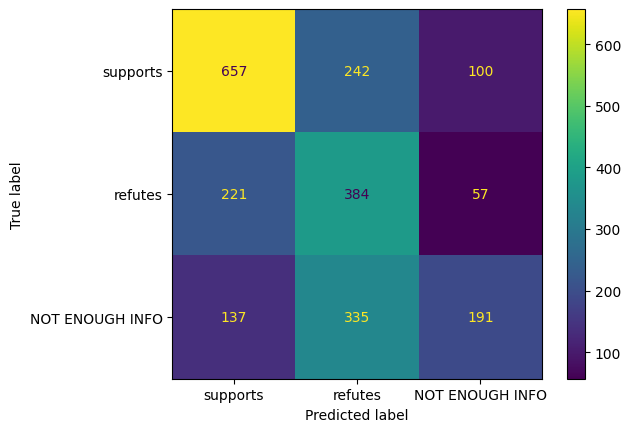

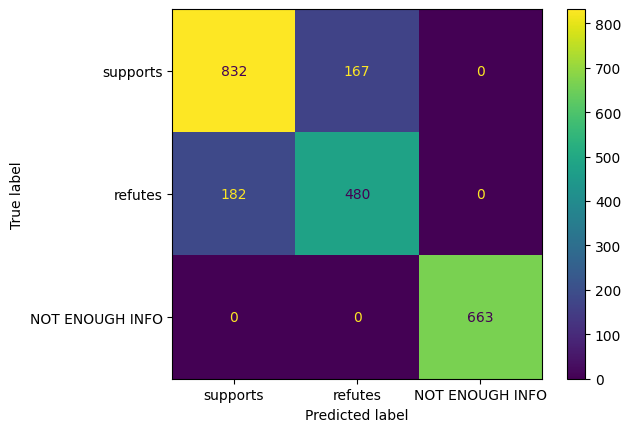

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classes = ["supports","refutes","NOT ENOUGH INFO"]
predicted_label2 = run_predict(model, eval_dataloader, device)
predicted_label3 = run_predict(model, val_t_dataloader, device)
true_label=dev_df["label"]
true_label=[LABEL2ID[idx] for idx in true_label]
confusion_mat = confusion_matrix(true_label, predicted_label2)
confusion_mat2 = confusion_matrix(true_label, predicted_label3)
print("Use predict evidence:")
disp = ConfusionMatrixDisplay (confusion_matrix=confusion_mat, display_labels=classes)
disp.plot(
  include_values=True,
  cmap="viridis",
  ax=None,
  xticks_rotation="horizontal",
  values_format="d")
print("Use true evidence:")
disp2 = ConfusionMatrixDisplay (confusion_matrix=confusion_mat2, display_labels=classes)
disp2.plot(
  include_values=True,
  cmap="viridis",
  ax=None,
  xticks_rotation="horizontal",
  values_format="d")
